In [4]:
import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open("raw_tables_2023_03_05/raw_tweets", "rb") as raw_timeline_file:
    tweet_df = pd.read_pickle(raw_timeline_file)
    # tweet_df.to_csv('raw_tweets_out.csv')
    print(tweet_df["content"].head(5))

0    I applaud North Carolina’s announcement to exp...
1    I’m so proud to have the Young Men’s Leadershi...
2    Happy Women’s History Month! When women succee...
3                    Stay safe out there, North Texas!
4    Wishing my fellow Texans everywhere a happy Te...
Name: content, dtype: object


In [40]:
from nltk.stem import PorterStemmer
import emoji

ps = PorterStemmer()

tweet_df_sample = tweet_df.sample(n = 10000)
tweet_df_sample.to_csv('tweet_df_sample.csv')

tweet_df_sample["content_words"] = tweet_df_sample["content"].apply(word_tokenize)
tweet_df_sample["content_words"] = tweet_df_sample["content_words"].apply(lambda words: [emoji.replace_emoji(ps.stem(word.lower())) for word in words])
tweet_df_sample["content_words_length"] = tweet_df_sample["content_words"].apply(len)

print(tweet_df_sample["content_words"].head(5))

4951620    [thank, you, ,, @, leaderhoy, ,, and, thank, y...
2178452    [democrat, are, ignor, our, immigr, law, subor...
3368071    [is, it, possibl, you, 're, take, thi, compari...
2735949    [honor, to, spend, the, even, pay, tribut, to,...
3825931    [thank, you, to, all, who, particip, in, thi, ...
Name: content_words, dtype: object


                  word  count      idf
25449                ✓      1  9.21044
12111      hillary2016      1  9.21044
12113      hillaryland      1  9.21044
12114         hillgrov      1  9.21044
21151             soft      1  9.21044
12116  hillsboroughsch      1  9.21044
12117             hilo      1  9.21044
12118           hilton      1  9.21044
25347      zelenskyyua      1  9.21044
12120             hime      1  9.21044


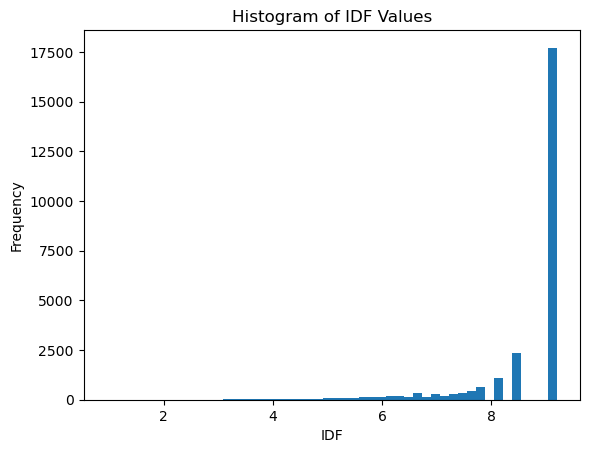

In [36]:
import numpy as np

id_list = []
word_list = []

for index, row in tweet_df_sample.iterrows():
    for word in set(row["content_words"]): 
        id_list.append(row["id"])
        word_list.append(word)


words_df = pd.DataFrame({"id": id_list, "word": word_list})
num_docs = tweet_df_sample.shape[0]

word_counts_df = words_df.groupby("word").count()
word_counts_df = word_counts_df.rename(columns={"id": "count"}).reset_index()
word_counts_df = word_counts_df.sort_values(by="count", ascending=True)

word_counts_df["idf"] = np.log(num_docs / word_counts_df["count"] + 1)

print(word_counts_df.head(10))

# Create a histogram of the IDF values
plt.hist(word_counts_df["idf"], bins=50)

# Set the plot title and axis labels
plt.title("Histogram of IDF Values")
plt.xlabel("IDF")
plt.ylabel("Frequency")

# Show the plot
plt.show()


In [37]:
word_counts_df.to_csv('word_counts_df.csv')
print(word_counts_df.shape)
print(num_docs)

(25450, 3)
10000


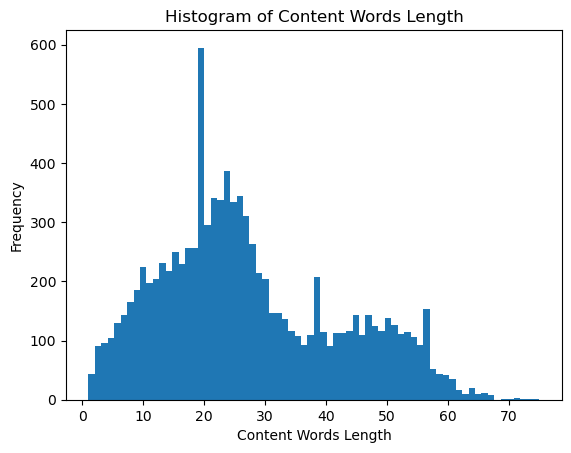

In [39]:
# Create a histogram of content_words_length
plt.hist(tweet_df_sample["content_words_length"], bins=70)

# Set the plot title and axis labels
plt.title("Histogram of Content Words Length")
plt.xlabel("Content Words Length")
plt.ylabel("Frequency")

# Show the plot
plt.show()

True     9113
False     887
Name: context_id, dtype: int64


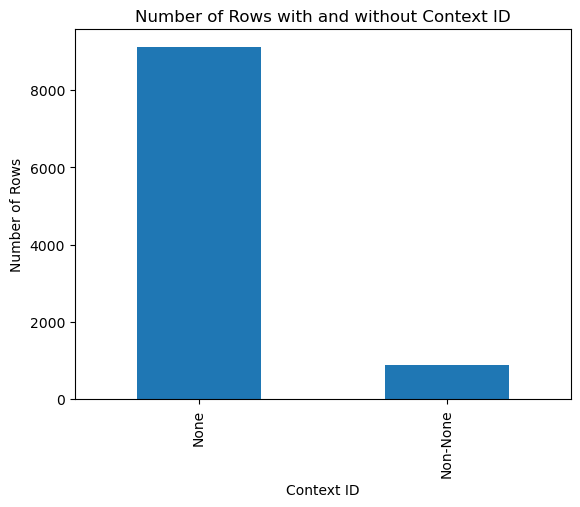

In [45]:
# Count the number of rows with and without a context_id value
context_counts = tweet_df_sample['context_id'].isna().value_counts()
print(context_counts)

# Create a bar chart of the context counts
context_counts.plot(kind='bar')

# Set the plot title and axis labels
plt.title('Number of Rows with and without Context ID')
plt.xlabel('Context ID')
plt.ylabel('Number of Rows')

# Set the x-axis tick labels
plt.xticks([0, 1], ['None', 'Non-None'])

# Show the plot
plt.show()